In [1]:
from autoencoder.data.tdms_to_npy_scaling import patch_matrix
a = patch_matrix(1500, save=True)

[nptdms.reader WARNING] Last segment of file has less data than expected, will attempt to read to the end of the file
[nptdms.reader WARNING] Last segment of file has less data than expected, will attempt to read to the end of the file
[nptdms.reader WARNING] Last segment of file has less data than expected, will attempt to read to the end of the file


ws_increment missing of autoencoder/data/tdms_files/P018_S01_D2023-10-04_G25.tdms in group R002 skipping the group


Kurtosis values:
fetal_clean           3.178344
maternal_clean        5.116444
maternal_shifted_1    5.116444
maternal_shifted_2    5.116444
fetal_noisy_1         2.977275
fetal_noisy_2         1.120994
fetal_noisy_3         1.374496
ecg_sum_no_noise_1    1.944178
ecg_sum_no_noise_2    0.630195
ecg_sum_noise_1       5.088929
ecg_sum_noise_2       1.351194
ecg_sum_noise_3       1.051109
ecg_sum_noise_4       5.128896
ecg_sum_noise_5       1.067534
ecg_sum_noise_6       1.040209
dtype: float64


<Figure size 1500x2000 with 0 Axes>

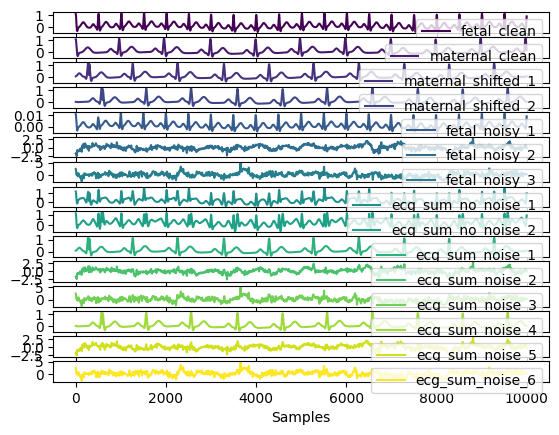

In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate ECG data with different configurations
fetal_clean = nk.ecg_simulate(duration=10, noise=0, heart_rate=120, sampling_rate=1000)
maternal_clean = nk.ecg_simulate(duration=10, noise=0, heart_rate=60, sampling_rate=1000)

# Introduce noise to the fetal ECG signals
fetal_noisy_1 = 0.01 * nk.ecg_simulate(duration=10, noise=0, heart_rate=120, sampling_rate=1000)
fetal_noisy_2 = 0.1 * nk.ecg_simulate(duration=10, noise=10, heart_rate=120, sampling_rate=1000)
fetal_noisy_3 = 0.1 * nk.ecg_simulate(duration=10, noise=15, heart_rate=120, sampling_rate=1000)

# Shift the maternal ECG to simulate fetal ECG at different delays
maternal_shifted_1 = np.roll(maternal_clean, 300)
maternal_shifted_2 = np.roll(maternal_clean, 600)

# Combine fetal and maternal ECG signals without noise
ecg_sum_no_noise_1 = fetal_clean + maternal_shifted_1
ecg_sum_no_noise_2 = fetal_clean + maternal_shifted_2

# Combine noisy fetal ECG signals with maternal ECG
ecg_sum_noise_1 = fetal_noisy_1 + maternal_shifted_1
ecg_sum_noise_2 = fetal_noisy_2 + maternal_shifted_1
ecg_sum_noise_3 = fetal_noisy_3 + maternal_shifted_1
ecg_sum_noise_4 = fetal_noisy_1 + maternal_shifted_2
ecg_sum_noise_5 = fetal_noisy_2 + maternal_shifted_2
ecg_sum_noise_6 = fetal_noisy_3 + maternal_shifted_2

# Create a DataFrame for visualization
ecg_df = pd.DataFrame(
    {
        "fetal_clean": fetal_clean,
        "maternal_clean": maternal_clean,
        "maternal_shifted_1": maternal_shifted_1,
        "maternal_shifted_2": maternal_shifted_2,
        "fetal_noisy_1": fetal_noisy_1,
        "fetal_noisy_2": fetal_noisy_2,
        "fetal_noisy_3": fetal_noisy_3,
        "ecg_sum_no_noise_1": ecg_sum_no_noise_1,
        "ecg_sum_no_noise_2": ecg_sum_no_noise_2,
        "ecg_sum_noise_1": ecg_sum_noise_1,
        "ecg_sum_noise_2": ecg_sum_noise_2,
        "ecg_sum_noise_3": ecg_sum_noise_3,
        "ecg_sum_noise_4": ecg_sum_noise_4,
        "ecg_sum_noise_5": ecg_sum_noise_5,
        "ecg_sum_noise_6": ecg_sum_noise_6
    })

# Calculate and print the kurtosis of each column in ecg_df
kurtosis_values = ecg_df.apply(stats.kurtosis)
print("Kurtosis values:")
print(kurtosis_values)

# Visualize the ECG signals with a larger figure
plt.figure(figsize=(15, 20))
nk.signal_plot(ecg_df, subplots=True)
plt.show()


In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

# Generate ECG data with different configurations
fetal_clean = nk.ecg_simulate(duration=6, noise=0, heart_rate=120, sampling_rate=1000)
maternal_clean = nk.ecg_simulate(duration=6, noise=0, heart_rate=60, sampling_rate=1000)

# Create a DataFrame for visualization
ecg_df = pd.DataFrame(
    {
        "fetal_clean": fetal_clean,
        "maternal_clean": maternal_clean,
    })


# Correlation Coefficient
correlation = np.corrcoef(ecg_df['fetal_clean'], ecg_df['maternal_clean'])[0, 1]
print(f'Correlation coefficient between fetal clean and maternal clean ECG: {correlation}')

# Discretize the data into bins
bins = 10000
fetal_clean_binned = pd.cut(ecg_df['fetal_clean'], bins, labels=False)
maternal_clean_binned = pd.cut(ecg_df['maternal_clean'], bins, labels=False)

# Calculate Mutual Information on binned data
mutual_info = mutual_info_score(fetal_clean_binned, maternal_clean_binned)
print(f'Mutual information between fetal clean and maternal clean ECG: {mutual_info}')




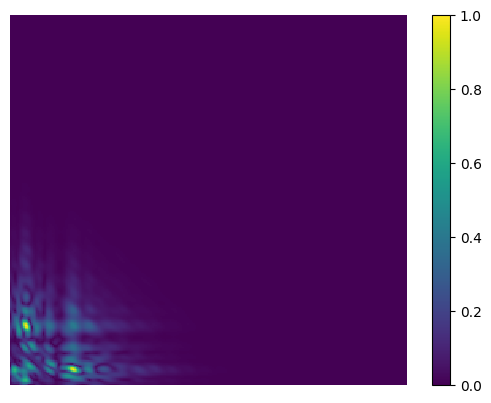

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import next_fast_len

from notebooks_freq.polycoherence import polycoherence

N = 10001
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, freq2, bispec = polycoherence(ecg_sum_no_noise_1, norm=None, fs=1000, **kw)

df1 = freq1[1] - freq1[0]
df2 = freq2[1] - freq2[0]
freq1 = np.append(freq1, freq1[-1] + df1) - 0.5 * df1
freq2 = np.append(freq2, freq2[-1] + df2) - 0.5 * df2
bispec_db = np.abs(bispec)

# Map the output values between 0 and 1
bispec_norm = (bispec_db - np.min(bispec_db)) / (np.max(bispec_db) - np.min(bispec_db))

plt.figure()
plt.pcolormesh(freq2, freq1, bispec_norm, vmin=0, vmax=1)
plt.xlabel('freq (Hz)')
plt.ylabel('freq (Hz)')
plt.xlim(0,50)
plt.ylim(0,50)
plt.colorbar()
plt.axis('off')
plt.savefig('my_image.png', bbox_inches='tight', pad_inches=0)